<a href="https://colab.research.google.com/github/Brian-ovita/Brian-ovita/blob/main/TextClassificationAccidentData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the required modules for this analysis: Text classification of accidents data to predict gender using Tensorflow (Keras)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

Use pandas to read in the relevant dataset

In [2]:
df = pd.read_csv("Accidents Data.csv")

In [3]:
df.head()

,Unnamed: 0,date,day,time_24_hours,county,road,place,type_of_vehicle,brief_accident_details,gender,age,weekend
0,1,1/2/2019,WEDNESDAY,550,SIAYA,SIAYA RANGALLA,RANGALLA AREA,PRIVATE,THE VEHICLE LOST CONTROL AND HIT A PAVEMENT,M,A,Weekday
1,2,1/3/2019,THURSDAY,450,KIAMBU,BOSTON QUARRY,NDARUGO AREA,COMMERCIAL,THE VEHICLE LOST CONTROL HITTING THE PERIMETER,M,35,Weekday
2,3,1/3/2019,THURSDAY,1230,KERICHO,KERICHO NAKURU,COMPLEX AREA,COMMERCIAL & PRIVATE,HEAD ON COLLISION,M,A,Weekday
3,4,1/8/2019,TUESDAY,1430,MURANGA,KENOL-MURANGA,KWA MUGURUKI,COMMERCIAL & PRIVATE,THE LORRY LOST CONTROL AND OVERTURNED,M,A,Weekday
4,5,1/9/2019,WEDNESDAY,UNKNOWN,KERICHO,KERICHO SOTIK,KENYA POWER AREA,PRIVATE,THE VEHICLE LOST CONTROL AND ROLLED SEVERAL TIMES,M,45,Weekday


Drop any null values in the relevant columns. `brief_accident_details` and `gender`

In [4]:
df = df.dropna(subset = ['brief_accident_details','gender'])

Create a binary label for the gender column. And select the columns to be used.

In [5]:
df['label'] = (df.gender=='M').astype(int)
df = df[['brief_accident_details','label']]

Split the data into training, validation and testing set

In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)),int(0.9*len(df))])
# check the lengths of the training, testing and validation sets
len(train),len(val),len(test)

(880, 110, 111)

In [7]:
## from tensorflow 
def df_to_dataset(dataframe, shuffle=True, batch_size=100):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['brief_accident_details']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

Use the function above; check out its documentation for further detail.

In [8]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

Model and Embedding

Embedding from tensorflowhub

In [9]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [10]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(100, 50), dtype=float32, numpy=
array([[ 0.02332125, -0.12362385, -0.65827215, ...,  0.03107429,
         0.02187134,  0.6050054 ],
       [ 0.11780404, -0.2323642 , -0.4872356 , ...,  0.00513672,
        -0.00733351,  0.34575745],
       [ 0.07807658, -0.24199101, -0.10317601, ..., -0.01636766,
         0.04145914,  0.26343694],
       ...,
       [ 0.0746401 , -0.14452197, -0.11350368, ...,  0.02377193,
         0.07130749,  0.27194247],
       [ 0.6924    , -0.15102494, -0.8189873 , ...,  0.28731516,
        -0.23022985,  0.78112453],
       [ 0.5381828 , -0.09843788, -1.1147205 , ...,  0.32241982,
        -0.31038147,  1.0588423 ]], dtype=float32)>

Create the model

In [11]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryFocalCrossentropy(),
              metrics=['accuracy'])

In [13]:
model.evaluate(train_data)

9/9 [==============================] - 2s 5ms/step - loss: 0.1403 - accuracy: 0.9091


[0.1403152495622635, 0.9090909361839294]

In [14]:
model.evaluate(valid_data)

2/2 [==============================] - 0s 5ms/step - loss: 0.1442 - accuracy: 0.8727


[0.14415055513381958, 0.8727272748947144]

In [15]:
history = model.fit(train_data, epochs=10, validation_data= valid_data)

Epoch 1/10
9/9 [==============================] - 6s 549ms/step - loss: 0.1345 - accuracy: 0.7591 - val_loss: 0.1066 - val_accuracy: 0.9182
Epoch 2/10
9/9 [==============================] - 5s 517ms/step - loss: 0.1201 - accuracy: 0.8489 - val_loss: 0.0909 - val_accuracy: 0.9091
Epoch 3/10
9/9 [==============================] - 5s 520ms/step - loss: 0.1067 - accuracy: 0.9091 - val_loss: 0.0836 - val_accuracy: 0.9091
Epoch 4/10
9/9 [==============================] - 5s 511ms/step - loss: 0.0925 - accuracy: 0.9239 - val_loss: 0.0808 - val_accuracy: 0.9091
Epoch 5/10
9/9 [==============================] - 5s 522ms/step - loss: 0.0955 - accuracy: 0.9261 - val_loss: 0.0803 - val_accuracy: 0.9091
Epoch 6/10
9/9 [==============================] - 5s 522ms/step - loss: 0.0841 - accuracy: 0.9330 - val_loss: 0.0798 - val_accuracy: 0.9091
Epoch 7/10
9/9 [==============================] - 5s 515ms/step - loss: 0.0744 - accuracy: 0.9364 - val_loss: 0.0796 - val_accuracy: 0.9091
Epoch 8/10
9/9 [====

Model Accuracy Plot

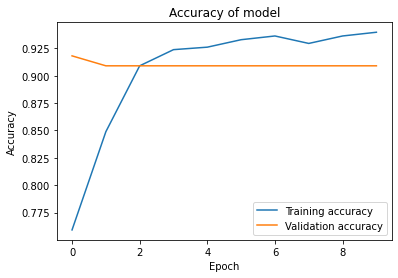

In [16]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Model Loss Plot

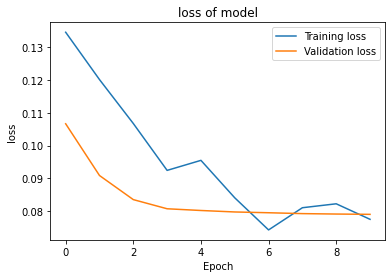

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss of model')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()